# Link dataset https://www.kaggle.com/datasets/ananthr1/weather-prediction

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Library

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.utils import to_categorical
from keras import layers

# Dataset

In [23]:
data = pd.read_csv("/content/drive/MyDrive/seattle-weather.csv")
data.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [24]:
print(data.info(), "\n")
print(data.describe(), "\n")
print("Shape:", data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB
None 

       precipitation     temp_max     temp_min         wind
count    1461.000000  1461.000000  1461.000000  1461.000000
mean        3.029432    16.439083     8.234771     3.241136
std         6.680194     7.349758     5.023004     1.437825
min         0.000000    -1.600000    -7.100000     0.400000
25%         0.000000    10.600000     4.400000     2.200000
50%         0.000000    15.600000     8.300000     3.000000
75%         2.800000    22.200000    12.200000     4.000000
ma

# Exploratory Data Analysis

In [25]:
data['date'] = pd.to_datetime(data['date'])
print(data.info(), "\n")
print(data["date"].head(), "\n")
print(data["date"].tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1461 non-null   datetime64[ns]
 1   precipitation  1461 non-null   float64       
 2   temp_max       1461 non-null   float64       
 3   temp_min       1461 non-null   float64       
 4   wind           1461 non-null   float64       
 5   weather        1461 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 68.6+ KB
None 

0   2012-01-01
1   2012-01-02
2   2012-01-03
3   2012-01-04
4   2012-01-05
Name: date, dtype: datetime64[ns] 

1456   2015-12-27
1457   2015-12-28
1458   2015-12-29
1459   2015-12-30
1460   2015-12-31
Name: date, dtype: datetime64[ns]


rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: weather, dtype: int64


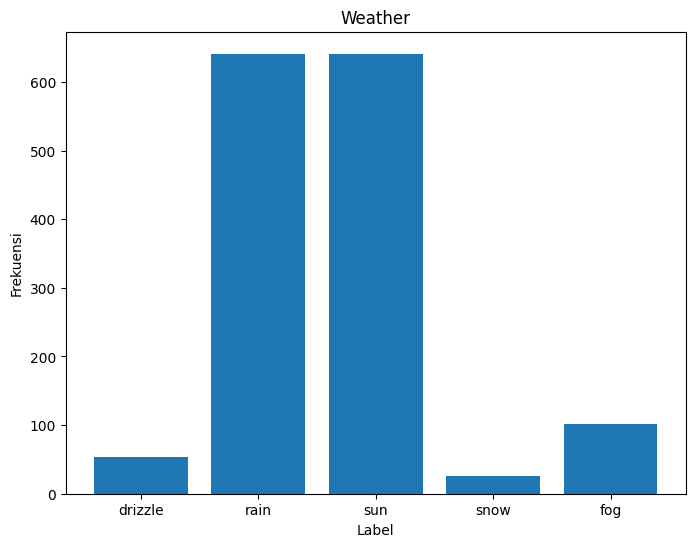

In [26]:
def fr_label(data, title):
  label_counts = Counter(data)
  label_names = list(label_counts.keys())
  label_frequencies = list(label_counts.values())
  plt.figure(figsize=(8, 6))
  plt.bar(label_names, label_frequencies)
  plt.xlabel('Label')
  plt.ylabel('Frekuensi')
  plt.title(title)
  plt.show()

print(data['weather'].value_counts())
fr_label(data["weather"], "Weather")

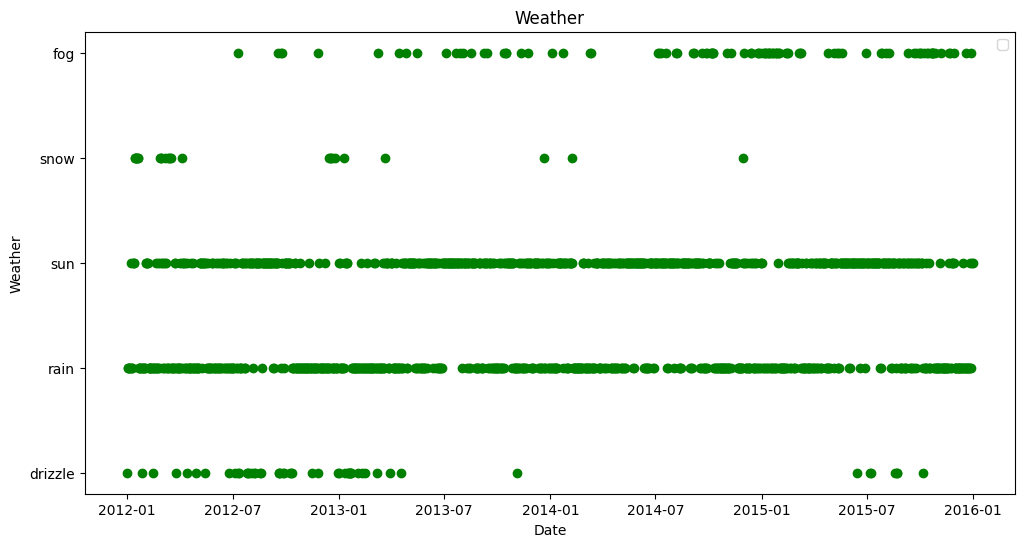

In [27]:
plt.figure(figsize=(12, 6))
plt.scatter(data["date"], data['weather'], color='g')
plt.title('Weather')
plt.xlabel('Date')
plt.ylabel('Weather')
plt.legend()
plt.show()

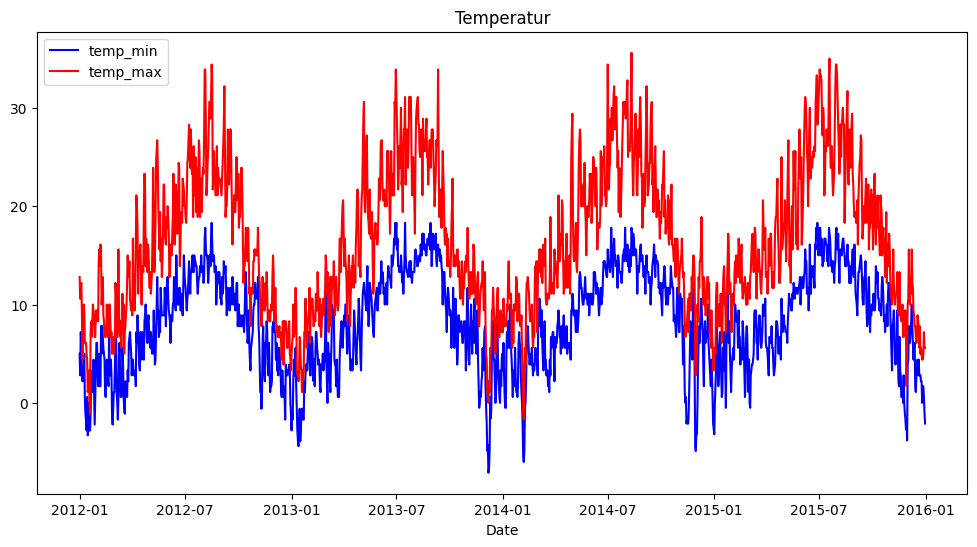

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(data["date"], data['temp_min'], color='b', label="temp_min")
plt.plot(data["date"], data["temp_max"], color='r', label="temp_max")
plt.title('Temperatur')
plt.xlabel('Date')
plt.legend()
plt.show()

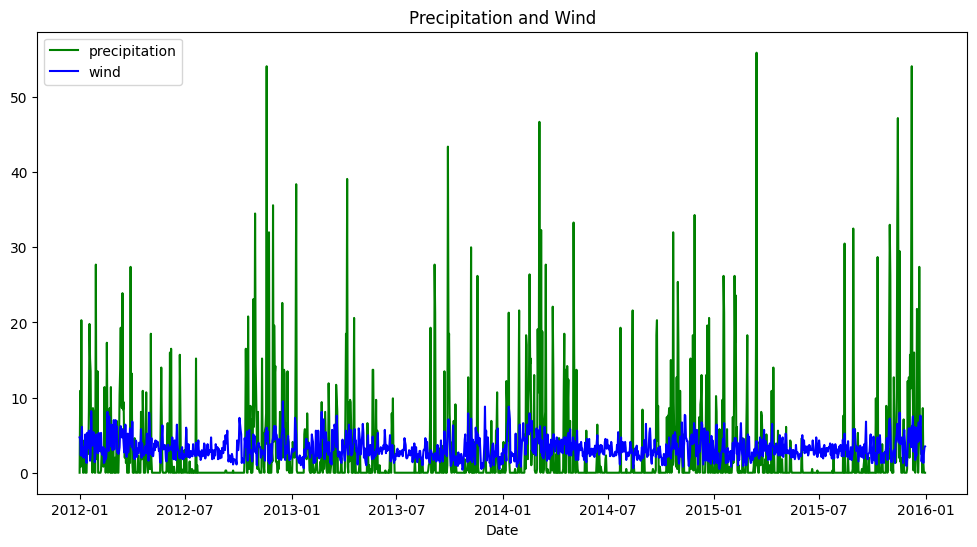

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(data["date"], data['precipitation'], color='g', label="precipitation")
plt.plot(data["date"], data["wind"], color='b', label="wind")
plt.title('Precipitation and Wind')
plt.xlabel('Date')
plt.legend()
plt.show()

# Analysis of Variance

In [30]:
def anova(x,y):
  anova_result = stats.f_oneway(
      x[y == 'rain'],
      x[y == 'sun'],
      x[y == 'fog'],
      x[y == 'snow'],
      x[y == 'drizzle']
  )
  print(f"F-Statistic: {anova_result.statistic}")
  print(f"P-Value: {anova_result.pvalue}")

col_list = [data["precipitation"], data["temp_max"],	data["temp_min"],	data["wind"]]
for i in range(len(col_list)):
  print(f"ANOVA test results for {data.columns[i+1]} on weather:")
  anova(col_list[i], data["weather"])
  print("\n")

ANOVA test results for precipitation on weather:
F-Statistic: 119.08602253977575
P-Value: 5.866414161486993e-88


ANOVA test results for temp_max on weather:
F-Statistic: 94.8386547733663
P-Value: 9.411574968646951e-72


ANOVA test results for temp_min on weather:
F-Statistic: 30.281943965457614
P-Value: 3.0874434723711254e-24


ANOVA test results for wind on weather:
F-Statistic: 40.77927354086677
P-Value: 1.986750256012372e-32




# Transition Probability

In [31]:
weather = data['weather'].unique()
transition_probability_matrix = pd.DataFrame(0, columns=weather, index=weather, dtype=float)

for i in range(1, len(data)):
  current_weather = data['weather'][i - 1]
  tomorrow_weather = data['weather'][i]
  transition_probability_matrix.loc[current_weather, tomorrow_weather] += 1

transition_probability_matrix = transition_probability_matrix.div(transition_probability_matrix.sum(axis=1), axis=0)
print("Transition Probability Matrix:\n")
print(transition_probability_matrix)

Transition Probability Matrix:

          drizzle      rain       sun      snow       fog
drizzle  0.301887  0.358491  0.283019  0.000000  0.056604
rain     0.028081  0.673947  0.224649  0.017161  0.056162
sun      0.025039  0.231612  0.682316  0.007825  0.053208
snow     0.038462  0.384615  0.192308  0.384615  0.000000
fog      0.009901  0.316832  0.396040  0.000000  0.277228


In [32]:
weather_states = data["weather"].unique().tolist()

def convert_initial_weather_to_probability(initial_weather):
  initial_probability = np.zeros(len(weather_states))
  if initial_weather in weather_states:
    initial_probability[weather_states.index(initial_weather)] = 1
  return initial_probability

latest_weather = data["weather"].iloc[-1]
initial_probability = convert_initial_weather_to_probability(latest_weather)

def calculate_weather_probabilities(n):
  probabilities = [initial_probability]
  current_probability = initial_probability
  for _ in range(n):
    current_probability = np.dot(current_probability, transition_probability_matrix)
    probabilities.append(current_probability)
  return probabilities

n_days = 7
weather_probabilities = calculate_weather_probabilities(n_days)

dt = data["date"].iloc[-1].date()
formatted_date = dt.strftime("%Y-%m-%d")
end_date = (dt + pd.DateOffset(days=n_days+1)).strftime("%Y-%m-%d")
print(f"Weather probability form date {formatted_date} to date {end_date}:\n")
for i, probability in enumerate(weather_probabilities):
  if i+1 == 1:
    current_date = (dt + pd.DateOffset(days=i)).strftime("%Y-%m-%d")
    print(f"Date {current_date} (Start Date):")
    print(f"Weather: {latest_weather}\n")
  else:
    current_date = (dt + pd.DateOffset(days=i)).strftime("%Y-%m-%d")
    print(f"Date {current_date}:")
    for state, p in zip(weather_states, probability):
      print(f"{state}: {p:.4f}")
    print()

Weather probability form date 2015-12-31 to date 2016-01-08:

Date 2015-12-31 (Start Date):
Weather: sun

Date 2016-01-01:
drizzle: 0.0250
rain: 0.2316
sun: 0.6823
snow: 0.0078
fog: 0.0532

Date 2016-01-02:
drizzle: 0.0320
rain: 0.3430
sun: 0.5473
snow: 0.0123
fog: 0.0655

Date 2016-01-03:
drizzle: 0.0341
rain: 0.3948
sun: 0.4878
snow: 0.0149
fog: 0.0683

Date 2016-01-04:
drizzle: 0.0348
rain: 0.4187
sun: 0.4611
snow: 0.0163
fog: 0.0690

Date 2016-01-05:
drizzle: 0.0351
rain: 0.4296
sun: 0.4490
snow: 0.0171
fog: 0.0692

Date 2016-01-06:
drizzle: 0.0353
rain: 0.4346
sun: 0.4435
snow: 0.0175
fog: 0.0692

Date 2016-01-07:
drizzle: 0.0353
rain: 0.4369
sun: 0.4410
snow: 0.0176
fog: 0.0692



# Models

In [33]:
X = data[['precipitation', 'temp_max', 'temp_min', 'wind']]
y = data['weather']

## Random Forest Classifier

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
random_forest = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Hyperparameter:", grid_search.best_params_)
best_random_forest = grid_search.best_estimator_
y_pred = best_random_forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Best Hyperparameter: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.84


## Time Series RNN

In [35]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(y)
data_normalized = (X - data.mean()) / X.std()
train_percent = 0.8
split_index = int(len(X) * train_percent)
X_train = data_normalized[:split_index]
y_train = labels_encoded[:split_index]
X_test = data_normalized[split_index:]
y_test = labels_encoded[split_index:]

<ipython-input-35-bfae98979c3d>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data_normalized = (X - data.mean()) / X.std()
<ipython-input-35-bfae98979c3d>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_normalized = (X - data.mean()) / X.std()


In [36]:
def build_model(units=64, activation='relu', optimizer='adam'):
  model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Reshape((1, X_train.shape[1])),    # Reshape data untuk RNN
    layers.LSTM(units),                      # Layer LSTM
    layers.Dense(32, activation=activation),  # Hidden layer
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
  ])
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

hyperparameters = {
  'units': [32, 64, 128],
  'activation': ['relu', 'tanh'],
  'optimizer': ['adam', 'rmsprop'],
}

best_accuracy = 0
best_model = None
best_hyperparameters = {}

for units in hyperparameters['units']:
  for activation in hyperparameters['activation']:
    for optimizer in hyperparameters['optimizer']:
      model = build_model(units=units, activation=activation, optimizer=optimizer)
      model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
      y_pred = model.predict(X_test)
      y_pred_classes = np.argmax(y_pred, axis=1)
      accuracy = accuracy_score(y_test, y_pred_classes)
      if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_hyperparameters = {'units': units, 'activation': activation, 'optimizer': optimizer}

print("Best Hyperparameter:", best_hyperparameters)
print(f'Accuracy: {best_accuracy}')
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

10/10 [==============================] - 0s 3ms/step
Best Hyperparameter: {'units': 64, 'activation': 'tanh', 'optimizer': 'adam'}
Accuracy: 0.8532423208191127
10/10 [==============================] - 0s 3ms/step
